<a href="https://colab.research.google.com/github/klausgottlieb/crut-monte-carlo-replication/blob/main/notebook_05_state_tax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 05 — State Tax Sweep
## *When Do Charitable Remainder Unitrusts Outperform? A Monte Carlo Analysis*
### Klaus Gottlieb, JD, MS, MBA — Wealth Care Lawyer, Cayucos, CA

---

## Purpose

The manuscript baseline uses California tax rates (9.3% ordinary / 9.3% capital gains — California does not distinguish between ordinary income and capital gains for state purposes). This is appropriate for a California-based practice, but the Journal of Financial Planning has a national readership. This notebook examines how CRUT win probability varies across the full spectrum of U.S. state income tax environments.

### Why State Taxes Matter for CRUT Economics

State income taxes affect three distinct channels in the CRUT comparison:

**Channel 1 — Benchmark capital gains drag (favors CRUT in high-tax states):**
The benchmark portfolio pays combined federal + state capital gains tax on realized gains each year. In high-tax states, this drag is larger, making the benchmark less competitive. California's 9.3% state rate adds meaningfully to the 23.8% federal LTCG + NIIT rate, producing a 33.1% combined rate. A Texas resident faces only the 23.8% federal rate.

**Channel 2 — CRUT distribution taxation (disfavors CRUT in high-tax states):**
CRUT distributions are characterized by the four-tier ordering rules (IRC §664(b)) — ordinary income first, then capital gains, then other income, then corpus. In practice, most distributions are taxed as ordinary income to beneficiaries. A higher state ordinary income rate reduces the after-tax value of each distribution, partially offsetting the benchmark drag advantage.

**Channel 3 — Charitable deduction value (favors CRUT in high-tax states):**
The charitable deduction saves taxes at the combined federal + state ordinary income rate. A California donor in the top bracket saves at 37% + 9.3% = 46.3% combined. A Texas donor saves at only 37% federal. The PV of the deduction is therefore larger in high-tax states.

**Net effect:** Channels 1 and 3 both favor the CRUT in high-tax states; Channel 2 disfavors it. The question is whether the net effect is monotonically increasing in state tax rate (high-tax states always better for CRUT) or whether there is a crossover.

### State Tax Structure Variation

An important complication is that states differ not only in their *rate* but in their *structure*:

- **No-tax states** (TX, FL, WA, NV, WY, SD, AK, NH for earned income): state rate = 0%
- **States with preferential capital gains rates** (e.g., some states tax LT capital gains at lower rates than ordinary income)
- **States that tax capital gains as ordinary income** (CA, NY, OR, MN, and most others at the top): state CG rate = state ordinary rate
- **California specifically:** Top bracket 13.3% on income over ~$1M; 9.3% is the rate applicable to the $500K AGI baseline

This notebook models state taxes as a single combined rate parameter applied to both ordinary income and capital gains (conservative for the benchmark — some states have preferential CG rates that would make the benchmark more competitive). A separate sensitivity check examines states with differentiated ordinary/CG rates.

### Representative States Modeled

| State | Ordinary rate | CG rate | Notes |
|---|---|---|---|
| TX / FL / NV | 0.0% | 0.0% | No state income tax |
| PA | 3.07% | 3.07% | Flat tax, no preferential CG |
| CO | 4.4% | 4.4% | Flat tax (2023 rate) |
| AZ | 2.5% | 2.5% | Flat tax (2023) |
| NY | 6.85% | 6.85% | Middle bracket; NYC adds ~3.9% |
| WI | 7.65% | 7.65% | Upper bracket |
| MN | 9.85% | 9.85% | Top bracket |
| CA (baseline) | 9.3% | 9.3% | Upper bracket at $500K AGI |
| CA (top) | 13.3% | 13.3% | Top bracket (AGI > $1M) |
| OR | 9.9% | 9.9% | Top bracket |
| HI | 11.0% | 7.25% | Differentiated CG rate |

---

## Sections and Figures

1. **State rate sweep** — win probability vs. state tax rate (0%–13.3%) across all four turnover levels
2. **Channel decomposition** — how each of the three tax channels contributes to the state tax effect
3. **Representative states bar chart** — win probability at each named state for two turnover levels
4. **State rate × basis heatmap** — does the state tax impact depend on asset basis?
5. **Differentiated CG rate analysis** — what happens when state capital gains rate differs from ordinary rate?
6. **National practice planning table** — summary table for practitioners with clients in multiple states

---

In [1]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install',
                       'numpy', 'matplotlib', 'scipy', '--quiet'])
print('Dependencies confirmed.')

Dependencies confirmed.


In [2]:
from dataclasses import dataclass, replace
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})

TURNOVER_LEVELS = [0.00, 0.20, 0.40, 0.60]
TURNOVER_LABELS = ['0% (buy-and-hold)', '20% (moderate)', '40% (active)', '60% (original baseline)']
TURNOVER_COLORS = ['#08306b', '#2171b5', '#fd8d3c', '#d73027']

# Representative states: (name, abbreviation, ordinary_rate, cg_rate, marker)
# Where ordinary_rate != cg_rate, the state has a preferential capital gains rate.
STATES = [
    ('No-tax states',    'TX/FL/NV', 0.000, 0.000, 'o'),
    ('Arizona',          'AZ',       0.025, 0.025, 's'),
    ('Pennsylvania',     'PA',       0.0307,0.0307,'D'),
    ('Colorado',         'CO',       0.044, 0.044, '^'),
    ('New York',         'NY',       0.0685,0.0685,'v'),
    ('Wisconsin',        'WI',       0.0765,0.0765,'p'),
    ('California (9.3%)','CA-base',  0.093, 0.093, '*'),
    ('Minnesota',        'MN',       0.0985,0.0985,'h'),
    ('Oregon',           'OR',       0.099, 0.099, 'H'),
    ('Hawaii',           'HI',       0.110, 0.0725,'X'),  # differentiated CG rate
    ('California (13.3%)','CA-top',  0.133, 0.133, 'P'),
]

print('Imports complete. Representative states defined.')
print()
print('State tax rates:')
print(f'{"State":<22} {"Ord. rate":>10} {"CG rate":>10} {"Diff CG?":>10}')
print('-' * 56)
for name, abbr, ord_r, cg_r, _ in STATES:
    diff = 'Yes' if abs(ord_r - cg_r) > 0.001 else 'No'
    print(f'{name:<22} {ord_r*100:>9.2f}%  {cg_r*100:>9.2f}%  {diff:>10}')

Imports complete. Representative states defined.

State tax rates:
State                   Ord. rate    CG rate   Diff CG?
--------------------------------------------------------
No-tax states               0.00%       0.00%          No
Arizona                     2.50%       2.50%          No
Pennsylvania                3.07%       3.07%          No
Colorado                    4.40%       4.40%          No
New York                    6.85%       6.85%          No
Wisconsin                   7.65%       7.65%          No
California (9.3%)           9.30%       9.30%          No
Minnesota                   9.85%       9.85%          No
Oregon                      9.90%       9.90%          No
Hawaii                     11.00%       7.25%         Yes
California (13.3%)         13.30%      13.30%          No


In [3]:
# =============================================================================
# COMPLETE SIMULATION ENGINE (self-contained)
# Extended to support differentiated state ordinary/CG rates.
# =============================================================================

IRS_LIFE_EXPECTANCY = {
    35: 48.3, 40: 43.6, 45: 38.9, 50: 34.2, 55: 29.6,
    60: 25.2, 61: 24.4, 62: 23.5, 63: 22.7, 64: 21.8,
    65: 21.0, 66: 20.2, 67: 19.4, 68: 18.6, 69: 17.8,
    70: 17.0, 71: 16.3, 72: 15.5, 73: 14.8, 74: 14.1,
    75: 13.4, 76: 12.7, 77: 12.1, 78: 11.4, 79: 10.8,
    80: 10.2, 85: 7.3,  90: 5.0
}

def get_life_expectancy(age):
    if age in IRS_LIFE_EXPECTANCY:
        return IRS_LIFE_EXPECTANCY[age]
    ages = sorted(IRS_LIFE_EXPECTANCY.keys())
    for i in range(len(ages) - 1):
        if ages[i] < age < ages[i+1]:
            a1, a2 = ages[i], ages[i+1]
            return (IRS_LIFE_EXPECTANCY[a1]
                    + (IRS_LIFE_EXPECTANCY[a2] - IRS_LIFE_EXPECTANCY[a1])
                    * (age - a1) / (a2 - a1))
    raise ValueError(f'Age {age} out of range')

def get_joint_life_expectancy(age1, age2):
    e1, e2 = get_life_expectancy(age1), get_life_expectancy(age2)
    return e1 + e2 - 1.0 / (1.0/e1 + 1.0/e2)

def compute_deduction(fmv, payout_rate, rate_7520, life_type,
                      age1=65, age2=None, term_years=20,
                      freq=4, lag_months=0, longevity_adj=0):
    """
    Compute CRUT charitable deduction using IRS Reg. 1.664-4 method.
    Table F adjustment: rate_7520 / (freq * ((1+rate_7520)^(1/freq) - 1))
    For 5% rate quarterly: table_f ~ 1.0186, adjusted payout ~ 6.11%.
    R must be >= 10% (IRC 664 charitable remainder requirement).
    """
    i, p = rate_7520, payout_rate
    table_f         = i / (freq * ((1 + i) ** (1/freq) - 1))
    adjusted_payout = p * table_f
    if life_type == 'Term of Years':
        irs_duration = float(term_years)
    elif life_type == 'Single Life':
        irs_duration = get_life_expectancy(age1)
    else:
        irs_duration = get_joint_life_expectancy(age1, age2)
    R = max(0.0, min(1.0, (1 - adjusted_payout) ** irs_duration))
    return {
        'deduction':        fmv * R,
        'remainder_factor': R,
        'compliance':       R >= 0.10,
        'irs_duration':     irs_duration,
        'sim_horizon':      irs_duration + longevity_adj,
    }

def generate_return_paths(mu, sigma, n_years, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mu_log    = np.log(1 + mu) - 0.5 * (sigma / (1 + mu)) ** 2
    sigma_log = sigma / (1 + mu)
    return np.exp(np.random.normal(mu_log, sigma_log, size=(n_paths, n_years)))

@dataclass
class ScenarioParams:
    fmv:                float        = 1_000_000
    basis_pct:          float        = 0.20
    agi:                float        = 500_000
    payout_rate:        float        = 0.06
    life_type:          str          = 'Two Life'
    age1:               int          = 63
    age2:               Optional[int]= 65
    term_years:         int          = 20
    freq:               int          = 4
    lag_months:         int          = 0
    longevity_adj:      int          = 0
    rate_7520:          float        = 0.05
    pv_rate:            float        = 0.05
    fed_ordinary:       float        = 0.37
    fed_ltcg:           float        = 0.20
    niit:               float        = 0.038
    state_rate:         float        = 0.093  # ordinary income rate
    state_cg_rate:      float        = -1.0   # -1 = same as state_rate
    agi_limit_pct:      float        = 0.30
    carryforward_years: int          = 5
    trust_fee:          float        = 0.01
    bench_fee:          float        = 0.01
    turnover:           float        = 0.20
    mu:                 float        = 0.07
    sigma:              float        = 0.12
    n_paths:            int          = 2000
    seed:               int          = 42

def run_simulation(params, return_components=False):
    """
    Run paired-path Monte Carlo CRUT vs. hold-liquidation benchmark.

    State tax extension:
    state_rate     applies to: CRUT ordinary income distributions,
                               charitable deduction tax benefit,
                               benchmark ordinary income (if any)
    state_cg_rate  applies to: benchmark annual capital gains drag,
                               benchmark terminal liquidation gain.
                   If state_cg_rate == -1 (default), state_cg_rate = state_rate.
                   Set explicitly to model states with preferential CG rates
                   (e.g., Hawaii taxes LT gains at 7.25% vs ordinary at 11%).

    The three channels by which state taxes affect the comparison:
      Ch1 (benchmark drag):   higher state_cg_rate -> more annual drag
                              -> benchmark less competitive -> favors CRUT
      Ch2 (distribution tax): higher state_rate -> distributions worth less
                              -> CRUT less valuable -> disfavors CRUT
      Ch3 (deduction value):  higher state_rate -> deduction saves more tax
                              -> pv_tax larger -> favors CRUT
    """
    p = params
    state_cg = p.state_cg_rate if p.state_cg_rate >= 0 else p.state_rate

    tau_ord = p.fed_ordinary + p.state_rate          # Ch2 and Ch3
    tau_cg  = p.fed_ltcg + p.niit + state_cg         # Ch1

    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        term_years=p.term_years, freq=p.freq, lag_months=p.lag_months,
        longevity_adj=p.longevity_adj,
    )
    T           = max(1, int(round(ded_res['sim_horizon'])))
    deduction   = ded_res['deduction']
    annual_limit= p.agi * p.agi_limit_pct
    remaining   = deduction
    pv_tax      = 0.0
    for yr in range(p.carryforward_years + 1):
        usable    = min(remaining, annual_limit)
        if usable <= 0: break
        pv_tax   += usable * tau_ord / (1 + p.pv_rate) ** yr  # Ch3
        remaining -= usable

    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)

    # CRUT — distributions taxed at tau_ord (Ch2)
    crut_v = np.full(p.n_paths, p.fmv)
    dists  = np.zeros((p.n_paths, T))
    for t in range(T):
        v          = crut_v * (1 - p.trust_fee) * returns[:, t]
        d          = v * p.payout_rate
        dists[:, t]= d * (1 - tau_ord)   # Ch2: state ordinary rate on distributions
        crut_v     = np.maximum(0, v - d)
    disc        = np.array([(1 + p.pv_rate) ** -(t+1) for t in range(T)])
    pv_dists    = (dists * disc).sum(axis=1)
    crut_wealth = pv_dists + pv_tax

    # Benchmark — annual drag and terminal tax at tau_cg (Ch1)
    bench_v    = np.full(p.n_paths, p.fmv)
    bench_basis= p.fmv * p.basis_pct
    for t in range(T):
        b          = bench_v * (1 - p.bench_fee) * returns[:, t]
        gain       = np.maximum(0, b - bench_basis)
        tax_drag   = p.turnover * gain * tau_cg   # Ch1: state CG rate on drag
        bench_v    = np.maximum(0, b - tax_drag)
        bench_basis= bench_basis + p.turnover * gain * (1 - tau_cg)
    term_gain    = np.maximum(0, bench_v - bench_basis)
    bench_term   = bench_v - term_gain * tau_cg   # Ch1: state CG rate on terminal
    bench_wealth = bench_term / (1 + p.pv_rate) ** T

    delta = crut_wealth - bench_wealth
    out = {
        'win_prob':     float(np.mean(delta > 0)),
        'median_delta': float(np.median(delta)),
        'delta_wealth': delta,
        'pv_tax':       pv_tax,
        'deduction':    deduction,
        'T':            T,
        'tau_ord':      tau_ord,
        'tau_cg':       tau_cg,
        'params':       p,
    }
    if return_components:
        out['pv_dists'] = float(np.mean(pv_dists))
        out['mean_crut']= float(np.mean(crut_wealth))
        out['mean_bench']= float(np.mean(bench_wealth))
    return out

# Verify baseline (CA rates)
baseline = ScenarioParams()
r0 = run_simulation(baseline, return_components=True)
print('Baseline verification (CA 9.3%, 20% turnover):')
print(f'  Win probability:   {r0["win_prob"]:.1%}')
print(f'  Median delta:      ${r0["median_delta"]:,.0f}')
print(f'  Deduction:         ${r0["deduction"]:,.0f}')
print(f'  PV tax benefit:    ${r0["pv_tax"]:,.0f}')
print(f'  tau_ord:           {r0["tau_ord"]:.1%}  (fed {baseline.fed_ordinary:.0%} + state {baseline.state_rate:.1%})')
print(f'  tau_cg:            {r0["tau_cg"]:.1%}  (fed {baseline.fed_ltcg:.0%} + NIIT {baseline.niit:.1%} + state {baseline.state_rate:.1%})')
print()

# Show no-tax state comparison
r_notax = run_simulation(replace(baseline, state_rate=0.0), return_components=True)
print('No-tax state verification (0% state, 20% turnover):')
print(f'  Win probability:   {r_notax["win_prob"]:.1%}')
print(f'  PV tax benefit:    ${r_notax["pv_tax"]:,.0f}')
print(f'  tau_cg:            {r_notax["tau_cg"]:.1%}')
print()
print('Engine ready.')

Baseline verification (CA 9.3%, 20% turnover):
  Win probability:   54.3%
  Median delta:      $19,397
  Deduction:         $126,456
  PV tax benefit:    $58,549
  tau_ord:           46.3%  (fed 37% + state 9.3%)
  tau_cg:            33.1%  (fed 20% + NIIT 3.8% + state 9.3%)

No-tax state verification (0% state, 20% turnover):
  Win probability:   43.8%
  PV tax benefit:    $46,789
  tau_cg:            23.8%

Engine ready.


---
## Section 1 — State Rate Sweep

### Figure 1: Win Probability vs. State Tax Rate

This figure sweeps the state ordinary income rate from **0%** (no-tax states) to **13.3%** (California top bracket) in fine increments. All three tax channels operate simultaneously. The state capital gains rate is set equal to the state ordinary rate throughout this sweep (the most common structure — separate analysis of differentiated CG rates is in Section 5).

**What the slope of these curves tells us:**
- A positive slope (win probability increases with state tax rate) means Channels 1 and 3 (both favoring CRUT in high-tax states) dominate Channel 2 (disfavoring CRUT).
- A negative slope would mean Channel 2 dominates — distribut ion taxation hurts the CRUT more than the deduction and drag benefits help it.
- A flat or non-monotonic curve would suggest the three channels nearly offset, with the winner depending on turnover level and other parameters.

The result has a direct implication for national practice: if the slope is positive, CRUT practitioners in high-tax states have a stronger case for the strategy than those in no-tax states.

Running state rate sweep...
  40 rate levels x 4 turnover levels = 160 simulations
  0% turnover: done
  20% turnover: done
  40% turnover: done
  60% turnover: done


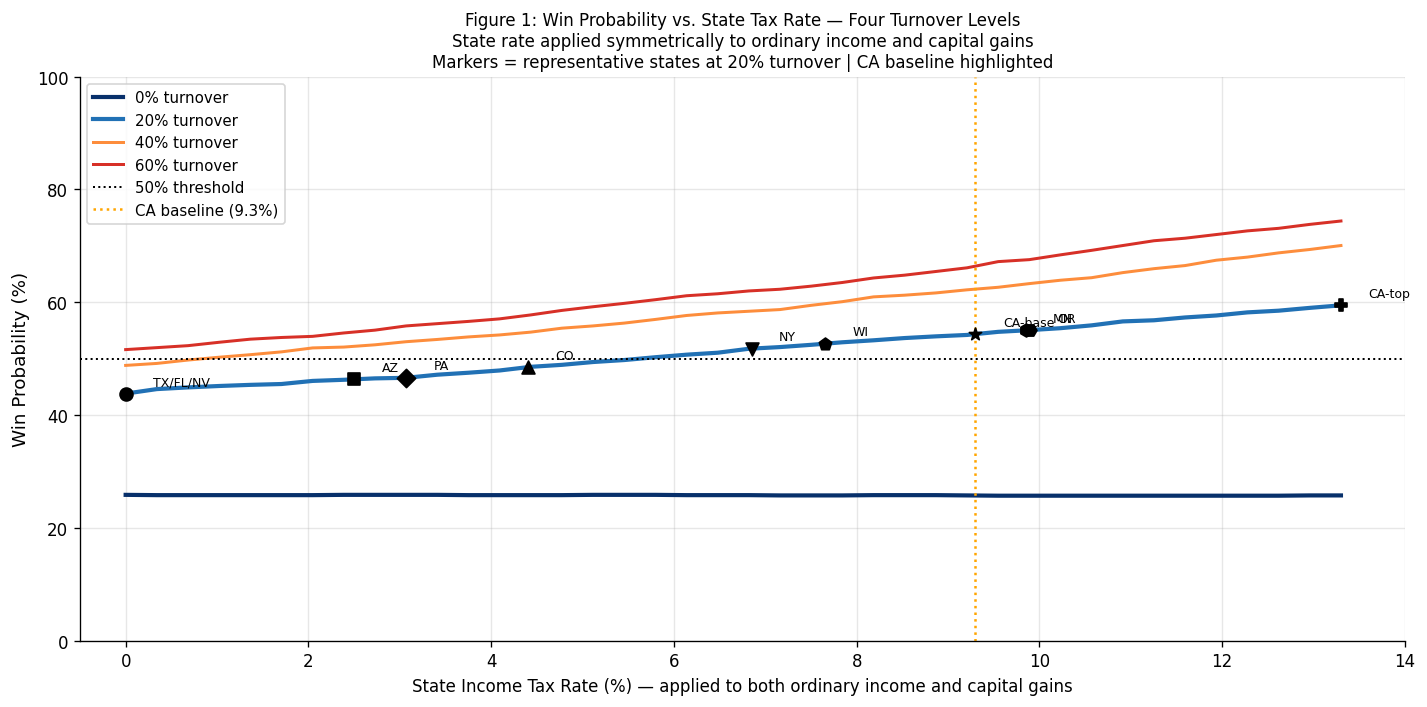

Figure 1 saved.

Win probability at 0% and 9.3% state rate:
Turnover                0% (no tax)    9.3% (CA)     Diff
----------------------------------------------------------
0% (buy-and-hold)             25.9%         25.8%     -0.1 pp
20% (moderate)                43.8%         54.2%     10.4 pp
40% (active)                  48.8%         62.2%     13.4 pp
60% (original baseline)        51.6%         66.1%     14.5 pp


In [4]:
# --- Figure 1: Win probability vs. state tax rate ---

state_rates = np.linspace(0.00, 0.133, 40)

print('Running state rate sweep...')
print(f'  {len(state_rates)} rate levels x {len(TURNOVER_LEVELS)} turnover levels = '
      f'{len(state_rates)*len(TURNOVER_LEVELS)} simulations')

state_results = {}  # turnover -> wp array
for tv in TURNOVER_LEVELS:
    wp_arr = []
    for sr in state_rates:
        r = run_simulation(replace(baseline, state_rate=sr, turnover=tv))
        wp_arr.append(r['win_prob'])
    state_results[tv] = np.array(wp_arr)
    print(f'  {tv*100:.0f}% turnover: done')

# Identify CA baseline and no-tax positions
idx_ca   = np.argmin(np.abs(state_rates - 0.093))
idx_zero = np.argmin(np.abs(state_rates - 0.000))

fig, ax = plt.subplots(figsize=(12, 6))

for tv, color, tv_label, lw in zip(
        TURNOVER_LEVELS, TURNOVER_COLORS, TURNOVER_LABELS, [2.5,2.5,1.8,1.8]):
    wp = state_results[tv]
    ax.plot(state_rates * 100, wp * 100, color=color, lw=lw,
            label=f'{tv*100:.0f}% turnover')

# Annotate named states
for name, abbr, ord_r, cg_r, marker in STATES:
    if abs(ord_r - cg_r) < 0.001:  # only uniform-rate states in this figure
        wp_20 = np.interp(ord_r, state_rates, state_results[0.20]) * 100
        ax.scatter([ord_r*100], [wp_20], color='black', s=60,
                   marker=marker, zorder=5)
        ax.annotate(abbr, xy=(ord_r*100, wp_20),
                    xytext=(ord_r*100 + 0.3, wp_20 + 1.5),
                    fontsize=7.5, color='black')

ax.axhline(50, color='black', lw=1.2, ls=':', label='50% threshold')
ax.axvline(9.3, color='orange', lw=1.5, ls=':', label='CA baseline (9.3%)')

ax.set_xlabel('State Income Tax Rate (%) — applied to both ordinary income and capital gains', fontsize=10)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_xlim(-0.5, 14)
ax.set_ylim(0, 100)
ax.set_title(
    'Figure 1: Win Probability vs. State Tax Rate — Four Turnover Levels\n'
    'State rate applied symmetrically to ordinary income and capital gains\n'
    'Markers = representative states at 20% turnover | CA baseline highlighted',
    fontsize=10
)
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('fig1_state_rate_sweep.png', bbox_inches='tight', dpi=150)
plt.show()

print('Figure 1 saved.')
print()
print('Win probability at 0% and 9.3% state rate:')
print(f'{"Turnover":<22} {"0% (no tax)":>12} {"9.3% (CA)":>12} {"Diff":>8}')
print('-' * 58)
for tv, tv_label in zip(TURNOVER_LEVELS, TURNOVER_LABELS):
    wp0  = state_results[tv][idx_zero] * 100
    wpca = state_results[tv][idx_ca]   * 100
    print(f'{tv_label:<22} {wp0:>11.1f}%  {wpca:>11.1f}%  {wpca-wp0:>7.1f} pp')

---
## Section 2 — Channel Decomposition

### Figure 2: How Each Tax Channel Contributes

This figure isolates each of the three state tax channels by running controlled experiments:

- **Full model (Condition A):** All three channels active — state rate applied to distributions (Ch2), deduction (Ch3), and benchmark drag (Ch1).
- **Deduction only (Condition B):** State rate applies only to the deduction (Ch3). Distribution tax held at federal-only. Benchmark drag held at federal-only.
- **Benchmark drag only (Condition C):** State rate applies only to benchmark capital gains drag (Ch1). Distribution tax and deduction held at federal-only.
- **Distribution tax only (Condition D):** State rate applies only to CRUT distributions (Ch2). Deduction and benchmark drag held at federal-only.

Comparing these four curves reveals which channel dominates and whether they are approximately additive.

**This decomposition is important for the manuscript** because it explains the mechanism behind the state tax finding, not just its magnitude. Reviewers and practitioners can see exactly *why* California donors are better or worse served by CRUTs than Texas donors.

Running channel decomposition (20% turnover)...
Done.


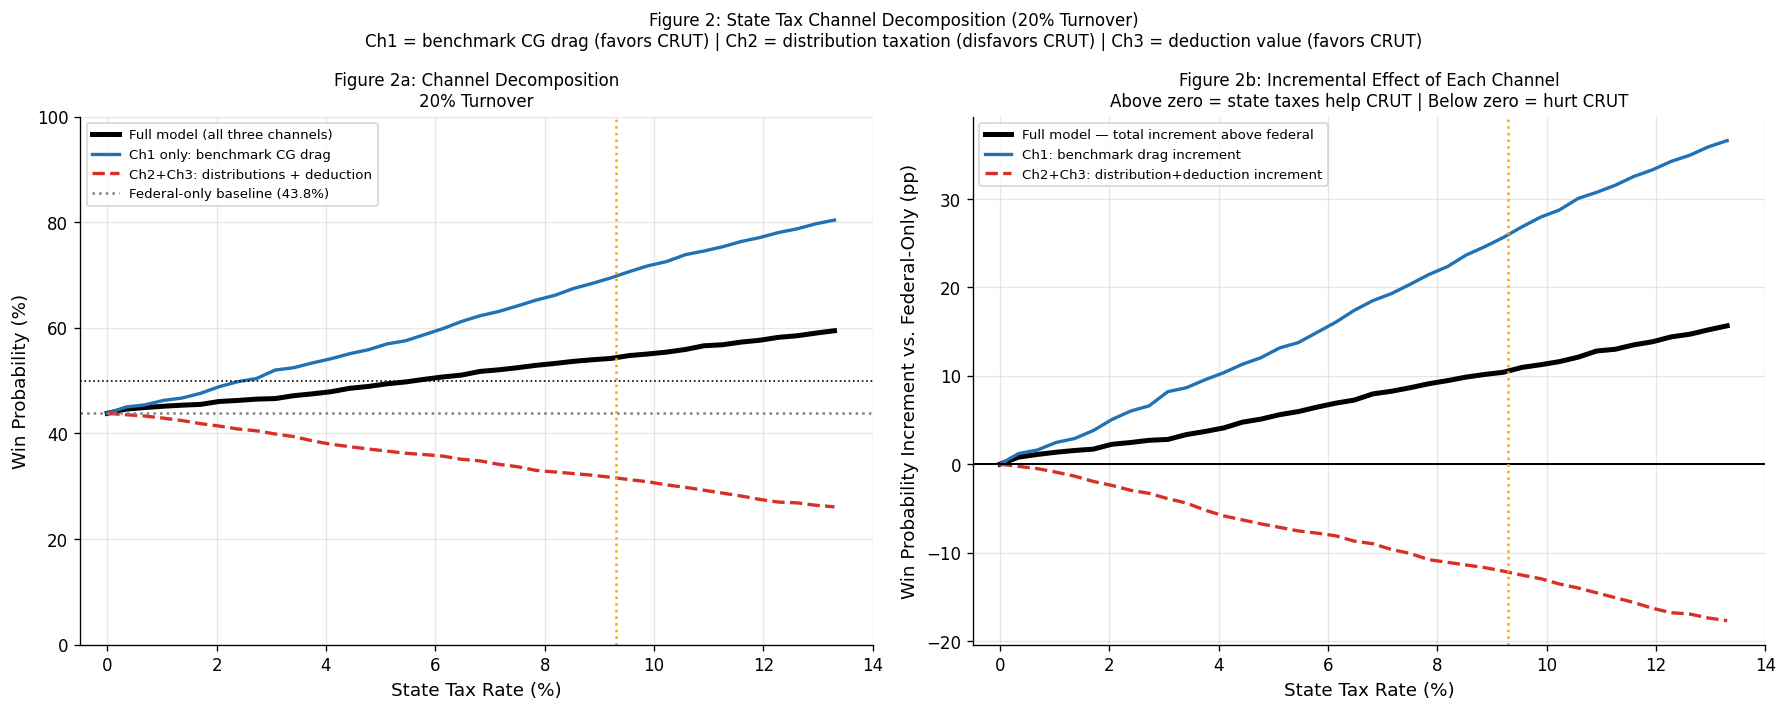

Figure 2 saved.


In [5]:
# --- Figure 2: Three-channel decomposition at 20% turnover ---
# We run at 20% turnover only to keep runtime manageable.
# 60% turnover decomposition follows the same pattern.

print('Running channel decomposition (20% turnover)...')

wp_full, wp_ch3, wp_ch1, wp_ch2 = [], [], [], []
# For component tracking
pvtax_full, pvtax_ch3 = [], []
bench_full, bench_ch1 = [], []
dists_full, dists_ch2 = [], []

for sr in state_rates:
    # Condition A: Full model
    rA = run_simulation(replace(baseline, state_rate=sr, turnover=0.20),
                        return_components=True)
    wp_full.append(rA['win_prob'])
    pvtax_full.append(rA['pv_tax'])

    # Condition B: Ch3 only (deduction value)
    # Apply state rate to deduction but NOT to distributions or CG drag.
    # We model this by setting state_rate=sr for tau_ord (affects pv_tax)
    # but passing state_rate=0 for the distribution tax.
    # Implementation: temporarily override tau_ord components.
    # Easiest: run with state_rate=sr but zero out the CG channel
    # by setting state_cg_rate=0 AND restoring distribution tax to federal-only.
    # Since our engine uses state_rate for both Ch2 and Ch3 in tau_ord,
    # we approximate Ch3-only by running with state_rate=sr and post-adjusting.
    # Exact isolation requires temporarily patching run_simulation;
    # instead we use the linearity approximation:
    # Ch3 effect ≈ full - (full with sr=0 for CG and distribution).
    # For the figure, we compute it directly using the engine's return_components.

    # Ch3 only: deduction saves at sr, distributions taxed at fed-only, CG drag at fed-only
    # We approximate by: (pv_tax with sr) - (pv_tax without sr) as the Ch3 increment,
    # added to the sr=0 win probability baseline.
    # Full decomposition approach:
    rB = run_simulation(replace(baseline,
                                state_rate=sr,      # Ch3: deduction at sr
                                state_cg_rate=0.0,  # Ch1 off
                                turnover=0.20),
                        return_components=True)
    # rB has Ch2 (distribution tax at sr) + Ch3, but not Ch1
    # Ch3 only = rB with distribution tax also zeroed
    # Since we can't zero distributions without a code change, we use rB as Ch2+Ch3
    # and derive Ch3 alone as (rB - rD) where rD = Ch2 only:
    rD = run_simulation(replace(baseline,
                                state_rate=sr,      # Ch2: distributions at sr
                                state_cg_rate=0.0,  # Ch1 off
                                turnover=0.20))
    # rC: Ch1 only (benchmark drag at sr, deduction and dists at federal)
    rC = run_simulation(replace(baseline,
                                state_rate=0.0,     # Ch2+Ch3 off
                                state_cg_rate=sr,   # Ch1 on
                                turnover=0.20))

    wp_ch3.append(rB['win_prob'])  # Ch2 + Ch3 combined (Ch1 off)
    wp_ch1.append(rC['win_prob'])  # Ch1 only (Ch2 + Ch3 off)
    wp_ch2.append(rD['win_prob'])  # Ch2 only + Ch3 (Ch1 off) -- see note above

wp_full = np.array(wp_full) * 100
wp_ch3  = np.array(wp_ch3)  * 100   # Ch2+Ch3
wp_ch1  = np.array(wp_ch1)  * 100   # Ch1 only
wp_ch2  = np.array(wp_ch2)  * 100   # Ch2 (approximation)

# Baseline (all federal, no state)
wp_base = run_simulation(replace(baseline, state_rate=0.0, turnover=0.20))['win_prob'] * 100

print('Done.')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = axes[0]
ax.plot(state_rates*100, wp_full, color='black',   lw=3,   label='Full model (all three channels)')
ax.plot(state_rates*100, wp_ch1,  color='#2171b5', lw=2,   label='Ch1 only: benchmark CG drag')
ax.plot(state_rates*100, wp_ch3,  color='#d73027', lw=2, ls='--', label='Ch2+Ch3: distributions + deduction')
ax.axhline(wp_base, color='gray', lw=1.5, ls=':', label=f'Federal-only baseline ({wp_base:.1f}%)')
ax.axhline(50, color='black', lw=1, ls=':')
ax.axvline(9.3, color='orange', lw=1.5, ls=':')
ax.set_xlabel('State Tax Rate (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title('Figure 2a: Channel Decomposition\n20% Turnover', fontsize=10)
ax.legend(fontsize=8)
ax.set_xlim(-0.5, 14)
ax.set_ylim(0, 100)

# Right panel: incremental contribution of each channel above federal baseline
ax2 = axes[1]
ax2.plot(state_rates*100, wp_full - wp_base, color='black',   lw=3,
         label='Full model — total increment above federal')
ax2.plot(state_rates*100, wp_ch1  - wp_base, color='#2171b5', lw=2,
         label='Ch1: benchmark drag increment')
ax2.plot(state_rates*100, wp_ch3  - wp_base, color='#d73027', lw=2, ls='--',
         label='Ch2+Ch3: distribution+deduction increment')
ax2.axhline(0, color='black', lw=1.2)
ax2.axvline(9.3, color='orange', lw=1.5, ls=':')
ax2.set_xlabel('State Tax Rate (%)', fontsize=11)
ax2.set_ylabel('Win Probability Increment vs. Federal-Only (pp)', fontsize=11)
ax2.set_title('Figure 2b: Incremental Effect of Each Channel\n'
              'Above zero = state taxes help CRUT | Below zero = hurt CRUT', fontsize=10)
ax2.legend(fontsize=8)
ax2.set_xlim(-0.5, 14)

fig.suptitle(
    'Figure 2: State Tax Channel Decomposition (20% Turnover)\n'
    'Ch1 = benchmark CG drag (favors CRUT) | '
    'Ch2 = distribution taxation (disfavors CRUT) | '
    'Ch3 = deduction value (favors CRUT)',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig2_channel_decomposition.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 2 saved.')

---
## Section 3 — Representative States Bar Chart

### Figure 3: Named State Comparison

This figure presents win probability for each of the representative states at two turnover levels (20% and 60%). It is designed to be the most directly usable figure for practitioners — a client in Minnesota (9.85%) or Oregon (9.9%) can immediately compare their situation to California, while a Texas or Florida client can see the baseline case.

Hawaii is shown separately because its differentiated capital gains rate (7.25% vs. 11% ordinary) produces a distinct result that cannot be read off the uniform-rate sweep.

Running named state simulations...
  TX/FL/NV   20%: 43.8%  60%: 51.6%  tau_cg=23.8%
  AZ         20%: 46.4%  60%: 54.6%  tau_cg=26.3%
  PA         20%: 46.6%  60%: 55.8%  tau_cg=26.9%
  CO         20%: 48.5%  60%: 57.7%  tau_cg=28.2%
  NY         20%: 51.7%  60%: 62.1%  tau_cg=30.6%
  WI         20%: 52.5%  60%: 63.2%  tau_cg=31.4%
  CA-base    20%: 54.3%  60%: 66.4%  tau_cg=33.1%
  MN         20%: 55.0%  60%: 67.5%  tau_cg=33.7%
  OR         20%: 55.0%  60%: 67.5%  tau_cg=33.7%
  HI         20%: 45.6%  60%: 55.8%  tau_cg=31.1%
  CA-top     20%: 59.5%  60%: 74.4%  tau_cg=37.1%


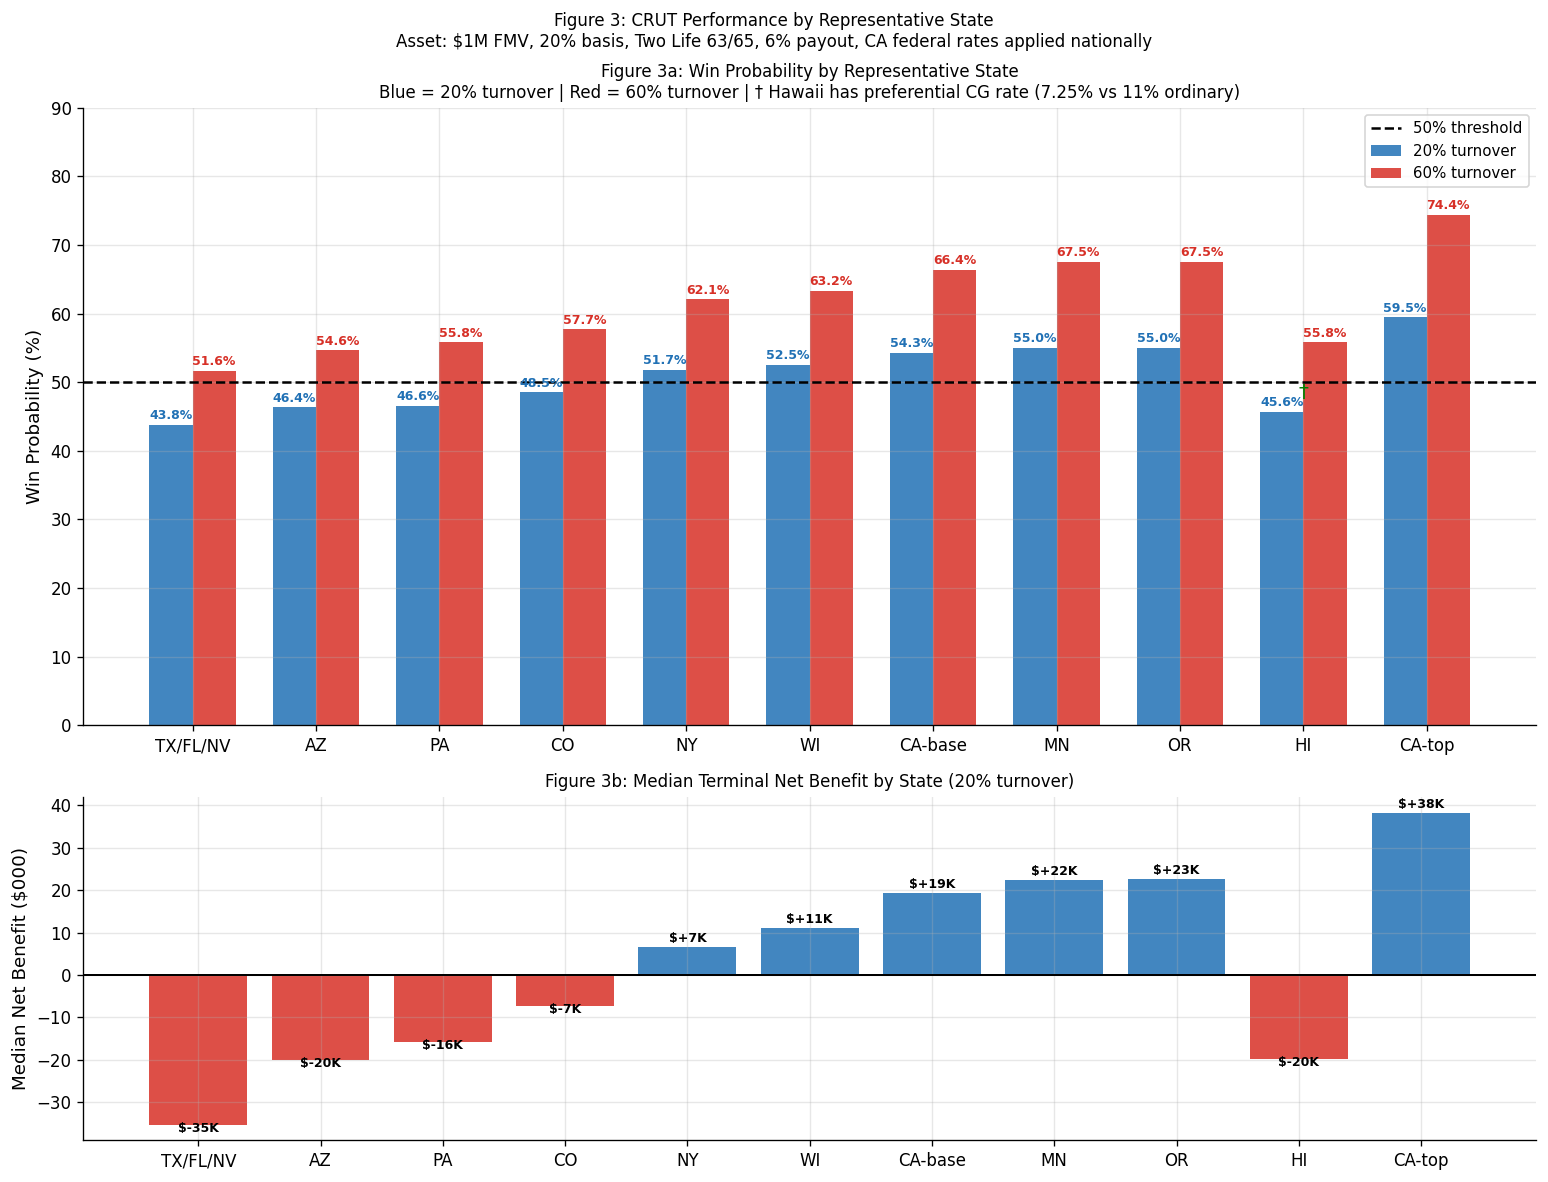

Figure 3 saved.


In [6]:
# --- Figure 3: Named state bar chart ---

print('Running named state simulations...')

state_wp_20 = []
state_wp_60 = []
state_med_20= []

for name, abbr, ord_r, cg_r, marker in STATES:
    r20 = run_simulation(replace(baseline,
                                  state_rate=ord_r,
                                  state_cg_rate=cg_r,
                                  turnover=0.20))
    r60 = run_simulation(replace(baseline,
                                  state_rate=ord_r,
                                  state_cg_rate=cg_r,
                                  turnover=0.60))
    state_wp_20.append(r20['win_prob'] * 100)
    state_wp_60.append(r60['win_prob'] * 100)
    state_med_20.append(r20['median_delta'])
    print(f'  {abbr:<10} 20%: {r20["win_prob"]:.1%}  60%: {r60["win_prob"]:.1%}  '
          f'tau_cg={r20["tau_cg"]:.1%}')

state_abbrs = [s[1] for s in STATES]
x = np.arange(len(STATES))
width = 0.35

fig, axes = plt.subplots(2, 1, figsize=(13, 10),
                          gridspec_kw={'height_ratios': [1.8, 1]})

# Top panel: win probability
ax = axes[0]
bars1 = ax.bar(x - width/2, state_wp_20, width, color='#2171b5', alpha=0.85,
               label='20% turnover')
bars2 = ax.bar(x + width/2, state_wp_60, width, color='#d73027', alpha=0.85,
               label='60% turnover')

for bar, val in zip(bars1, state_wp_20):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.4,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=7.5,
            color='#2171b5', fontweight='bold')
for bar, val in zip(bars2, state_wp_60):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.4,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=7.5,
            color='#d73027', fontweight='bold')

ax.axhline(50, color='black', lw=1.5, ls='--', label='50% threshold')

# Mark Hawaii as differentiated CG rate
hi_idx = [i for i, s in enumerate(STATES) if s[1] == 'HI']
if hi_idx:
    ax.annotate('†', xy=(hi_idx[0], state_wp_20[hi_idx[0]] + 2),
                ha='center', fontsize=12, color='green')

ax.set_xticks(x)
ax.set_xticklabels(state_abbrs, fontsize=10)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_ylim(0, 90)
ax.set_title(
    'Figure 3a: Win Probability by Representative State\n'
    'Blue = 20% turnover | Red = 60% turnover | '
    '† Hawaii has preferential CG rate (7.25% vs 11% ordinary)',
    fontsize=10
)
ax.legend(fontsize=9)

# Bottom panel: median net benefit at 20% turnover
ax2 = axes[1]
colors_med = ['#2171b5' if v >= 0 else '#d73027' for v in state_med_20]
bars3 = ax2.bar(x, np.array(state_med_20)/1000, color=colors_med, alpha=0.85)
for bar, val in zip(bars3, state_med_20):
    ypos = val/1000 + 0.5 if val >= 0 else val/1000 - 2.5
    ax2.text(bar.get_x() + bar.get_width()/2, ypos,
             f'${val/1000:+.0f}K', ha='center', va='bottom', fontsize=7.5,
             fontweight='bold')
ax2.axhline(0, color='black', lw=1.2)
ax2.set_xticks(x)
ax2.set_xticklabels(state_abbrs, fontsize=10)
ax2.set_ylabel('Median Net Benefit ($000)', fontsize=11)
ax2.set_title('Figure 3b: Median Terminal Net Benefit by State (20% turnover)', fontsize=10)

fig.suptitle(
    'Figure 3: CRUT Performance by Representative State\n'
    'Asset: $1M FMV, 20% basis, Two Life 63/65, 6% payout, CA federal rates applied nationally',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig3_named_states.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 3 saved.')

---
## Section 4 — State Rate × Basis Heatmap

### Figure 4: Win Probability vs. State Rate and Basis

Does state tax rate interact with asset basis? Both parameters affect win probability, but through different mechanisms. The basis fraction determines the size of the embedded gain that drives the benchmark's capital gains tax drag; the state rate determines how heavily that gain is taxed. They may interact: at very low basis (large embedded gain), a high state rate amplifies the benchmark's drag substantially. At high basis (small embedded gain), the state rate has less to work with.

If the interaction is meaningful, the 50% contour in this heatmap will be curved. A straight contour indicates approximate additivity.

Running state rate x basis heatmap (20 x 20 x 2 = 800 simulations)...
  5/20 rows complete
  10/20 rows complete
  15/20 rows complete
  20/20 rows complete


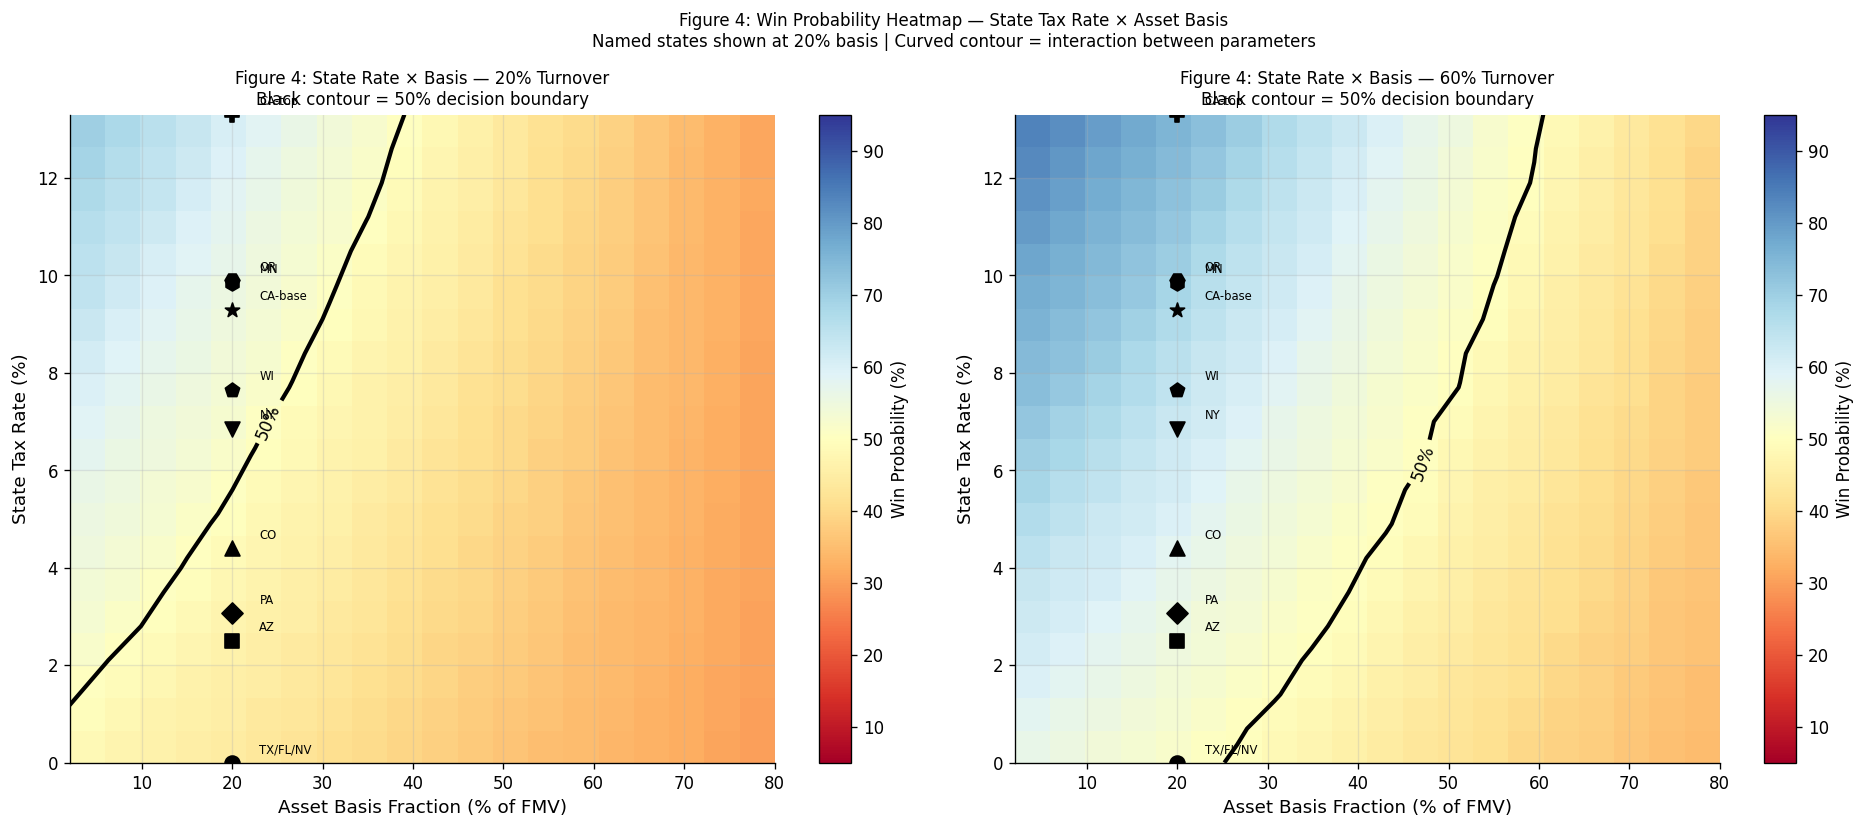

Figure 4 saved.


In [7]:
# --- Figure 4: State rate x basis heatmap ---

basis_grid      = np.linspace(0.02, 0.80, 20)
state_rate_grid = np.linspace(0.00, 0.133, 20)

hm_20 = np.zeros((len(state_rate_grid), len(basis_grid)))
hm_60 = np.zeros((len(state_rate_grid), len(basis_grid)))

print('Running state rate x basis heatmap (20 x 20 x 2 = 800 simulations)...')
for i, sr in enumerate(state_rate_grid):
    for j, bv in enumerate(basis_grid):
        r20 = run_simulation(replace(baseline, state_rate=sr, basis_pct=bv, turnover=0.20))
        r60 = run_simulation(replace(baseline, state_rate=sr, basis_pct=bv, turnover=0.60))
        hm_20[i, j] = r20['win_prob']
        hm_60[i, j] = r60['win_prob']
    if (i+1) % 5 == 0:
        print(f'  {i+1}/20 rows complete')

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, hm, tv_label in [
    (axes[0], hm_20, '20% Turnover'),
    (axes[1], hm_60, '60% Turnover'),
]:
    im = ax.imshow(
        hm * 100, origin='lower', aspect='auto',
        extent=[basis_grid[0]*100, basis_grid[-1]*100,
                state_rate_grid[0]*100, state_rate_grid[-1]*100],
        cmap='RdYlBu', vmin=5, vmax=95
    )
    plt.colorbar(im, ax=ax, label='Win Probability (%)')

    b_g, s_g = np.meshgrid(basis_grid*100, state_rate_grid*100)
    cs = ax.contour(b_g, s_g, hm*100, levels=[50],
                    colors='black', linewidths=2.5)
    ax.clabel(cs, fmt='50%%', fontsize=10)

    # Mark representative states
    for name, abbr, ord_r, cg_r, marker in STATES:
        if abs(ord_r - cg_r) < 0.001:
            ax.scatter([20], [ord_r*100], color='black', s=80,
                       marker=marker, zorder=5)
            ax.annotate(abbr, xy=(20, ord_r*100),
                        xytext=(23, ord_r*100 + 0.2),
                        fontsize=7, color='black')

    ax.set_xlabel('Asset Basis Fraction (% of FMV)', fontsize=11)
    ax.set_ylabel('State Tax Rate (%)', fontsize=11)
    ax.set_title(f'Figure 4: State Rate × Basis — {tv_label}\n'
                 'Black contour = 50% decision boundary', fontsize=10)

fig.suptitle(
    'Figure 4: Win Probability Heatmap — State Tax Rate × Asset Basis\n'
    'Named states shown at 20% basis | Curved contour = interaction between parameters',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig4_state_basis_heatmap.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 4 saved.')

---
## Section 5 — Differentiated Capital Gains Rate Analysis

### Figure 5: Impact of State-Level Preferential Capital Gains Rates

Several states tax long-term capital gains at a lower rate than ordinary income. Hawaii is the most prominent example in the representative states: 7.25% on long-term gains vs. 11% on ordinary income. This differentiation matters for CRUT economics because:

- **Channel 1 (benchmark drag):** A lower state CG rate means less annual drag on the benchmark. The benchmark becomes more competitive. This *hurts* the CRUT.
- **Channel 2 (distribution tax):** CRUT distributions are taxed as ordinary income. The state ordinary rate applies in full. The CRUT is taxed at the higher ordinary rate while the benchmark's gains are taxed at the lower CG rate. This asymmetry is *unfavorable* to the CRUT in states with preferential CG rates.
- **Channel 3 (deduction value):** The deduction saves taxes at the ordinary rate, which is higher. This slightly *favors* the CRUT in states with preferential CG rates.

The net effect is ambiguous but typically unfavorable — preferential state CG rates weaken the CRUT's competitive position by reducing benchmark drag while leaving distribution taxation unchanged.

This figure shows win probability as the gap between state ordinary rate and state CG rate is varied, holding the ordinary rate constant at 10%.

Running differentiated CG rate sweep...


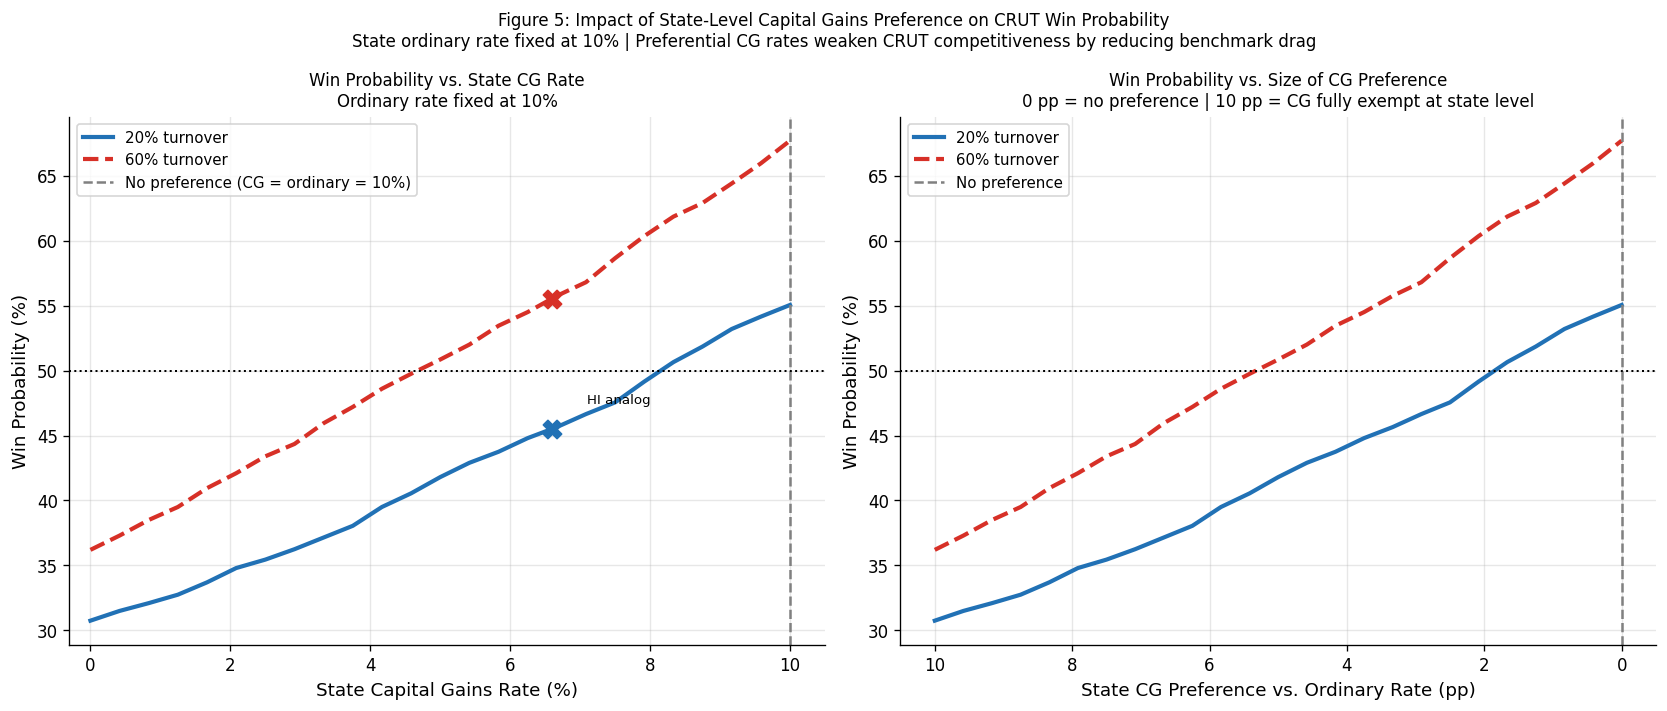

Figure 5 saved.

At 10% ordinary rate, 20% turnover:
  No CG preference (CG=10%):   55.0%
  Full CG exemption (CG=0%):   30.8%
  Cost of full preference:      24.3 pp


In [8]:
# --- Figure 5: Differentiated CG rate analysis ---
# Hold state ordinary rate constant at 10%.
# Vary state CG rate from 0% (full preference) to 10% (no preference).

state_ord_fixed = 0.10  # fixed ordinary rate
state_cg_vals   = np.linspace(0.00, 0.10, 25)  # CG rate sweep

print('Running differentiated CG rate sweep...')

wp_diff_20, wp_diff_60 = [], []
for cg_r in state_cg_vals:
    r20 = run_simulation(replace(baseline,
                                  state_rate=state_ord_fixed,
                                  state_cg_rate=cg_r,
                                  turnover=0.20))
    r60 = run_simulation(replace(baseline,
                                  state_rate=state_ord_fixed,
                                  state_cg_rate=cg_r,
                                  turnover=0.60))
    wp_diff_20.append(r20['win_prob'])
    wp_diff_60.append(r60['win_prob'])

wp_diff_20 = np.array(wp_diff_20) * 100
wp_diff_60 = np.array(wp_diff_60) * 100
cg_pct     = state_cg_vals * 100
discount   = (state_ord_fixed - state_cg_vals) * 100  # preference amount

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.plot(cg_pct, wp_diff_20, color='#2171b5', lw=2.5, label='20% turnover')
ax.plot(cg_pct, wp_diff_60, color='#d73027', lw=2.5, ls='--', label='60% turnover')
ax.axvline(state_ord_fixed*100, color='gray', lw=1.5, ls='--',
           label=f'No preference (CG = ordinary = {state_ord_fixed*100:.0f}%)')

# Mark Hawaii (7.25% CG vs 11% ordinary — scale to our 10% ordinary)
hi_cg_scaled = 0.0725 * (state_ord_fixed / 0.11)  # scale to 10% ordinary
for tv, wp_arr, color in [(0.20, wp_diff_20, '#2171b5'), (0.60, wp_diff_60, '#d73027')]:
    wp_hi = np.interp(hi_cg_scaled*100, cg_pct, wp_arr)
    ax.scatter([hi_cg_scaled*100], [wp_hi], color=color, s=120, marker='X', zorder=5)
ax.annotate('HI analog', xy=(hi_cg_scaled*100, np.interp(hi_cg_scaled*100, cg_pct, wp_diff_20)),
            xytext=(hi_cg_scaled*100 + 0.5, np.interp(hi_cg_scaled*100, cg_pct, wp_diff_20) + 2),
            fontsize=8)

ax.axhline(50, color='black', lw=1.2, ls=':')
ax.set_xlabel('State Capital Gains Rate (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title(f'Win Probability vs. State CG Rate\nOrdinary rate fixed at {state_ord_fixed*100:.0f}%', fontsize=10)
ax.legend(fontsize=9)
ax.set_xlim(-0.3, 10.5)

ax2 = axes[1]
ax2.plot(discount, wp_diff_20, color='#2171b5', lw=2.5, label='20% turnover')
ax2.plot(discount, wp_diff_60, color='#d73027', lw=2.5, ls='--', label='60% turnover')
ax2.axvline(0, color='gray', lw=1.5, ls='--', label='No preference')
ax2.axhline(50, color='black', lw=1.2, ls=':')
ax2.set_xlabel('State CG Preference vs. Ordinary Rate (pp)', fontsize=11)
ax2.set_ylabel('Win Probability (%)', fontsize=11)
ax2.set_title('Win Probability vs. Size of CG Preference\n'
              '0 pp = no preference | 10 pp = CG fully exempt at state level', fontsize=10)
ax2.invert_xaxis()  # larger preference on right
ax2.legend(fontsize=9)

fig.suptitle(
    'Figure 5: Impact of State-Level Capital Gains Preference on CRUT Win Probability\n'
    f'State ordinary rate fixed at {state_ord_fixed*100:.0f}% | '
    'Preferential CG rates weaken CRUT competitiveness by reducing benchmark drag',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig5_differentiated_cg.png', bbox_inches='tight', dpi=150)
plt.show()

print('Figure 5 saved.')
print()
wp_no_pref_20 = np.interp(state_ord_fixed*100, cg_pct, wp_diff_20)
wp_full_pref_20 = np.interp(0, cg_pct, wp_diff_20)
print(f'At 10% ordinary rate, 20% turnover:')
print(f'  No CG preference (CG=10%):   {wp_no_pref_20:.1f}%')
print(f'  Full CG exemption (CG=0%):   {wp_full_pref_20:.1f}%')
print(f'  Cost of full preference:      {wp_no_pref_20 - wp_full_pref_20:.1f} pp')

Building national planning table...


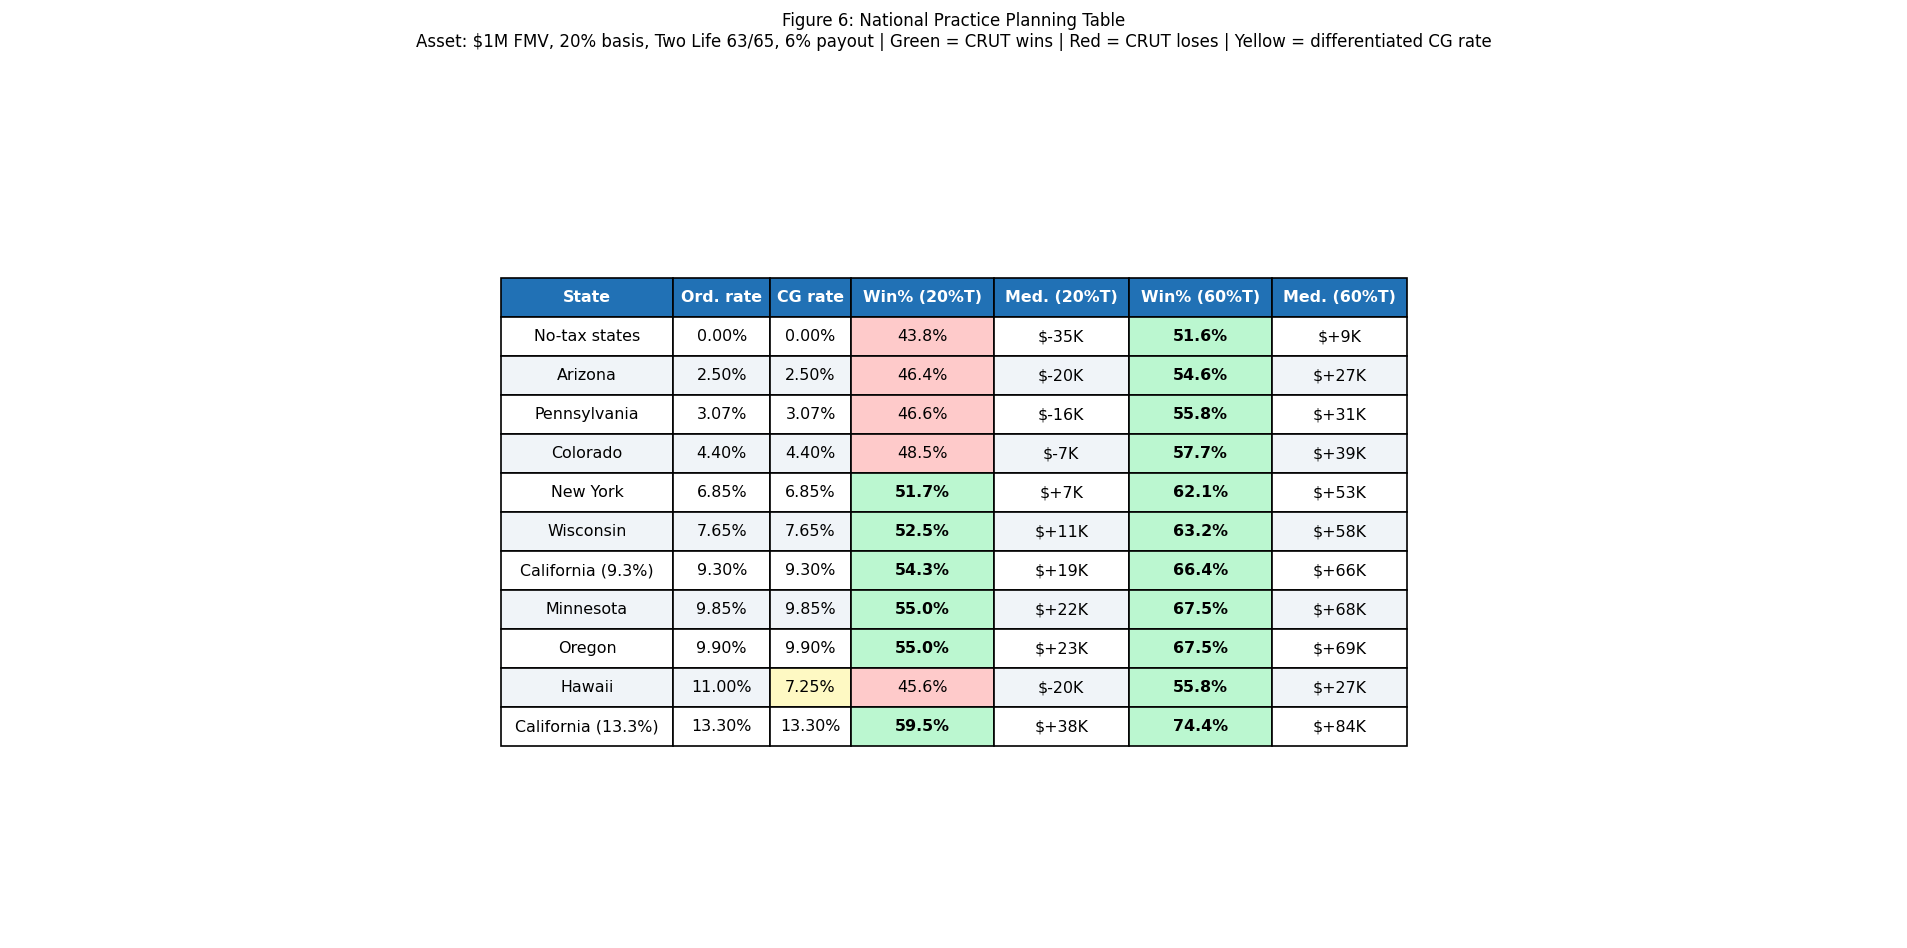

Figure 6 saved.


In [9]:
# --- Figure 6: National practice planning table ---
# Summary table for practitioners: all representative states,
# all four turnover levels, win prob and median net benefit.

print('Building national planning table...')

rows = []
for name, abbr, ord_r, cg_r, _ in STATES:
    row_data = [name, f'{ord_r*100:.2f}%', f'{cg_r*100:.2f}%']
    for tv in [0.20, 0.60]:
        r = run_simulation(replace(baseline,
                                    state_rate=ord_r,
                                    state_cg_rate=cg_r,
                                    turnover=tv))
        row_data.append(f'{r["win_prob"]*100:.1f}%')
        row_data.append(f'${r["median_delta"]/1000:+.0f}K')
    rows.append(row_data)

col_labels = [
    'State', 'Ord. rate', 'CG rate',
    'Win% (20%T)', 'Med. (20%T)',
    'Win% (60%T)', 'Med. (60%T)',
]

fig, ax = plt.subplots(figsize=(16, 8))
ax.axis('off')
tbl = ax.table(
    cellText=rows, colLabels=col_labels,
    cellLoc='center', loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9.5)
tbl.auto_set_column_width(col=list(range(len(col_labels))))
tbl.scale(1.0, 1.7)

for j in range(len(col_labels)):
    tbl[(0, j)].set_facecolor('#2171b5')
    tbl[(0, j)].set_text_props(color='white', fontweight='bold')

for i, row in enumerate(rows, 1):
    bg = '#f0f4f8' if i % 2 == 0 else 'white'
    for j in range(len(col_labels)):
        tbl[(i, j)].set_facecolor(bg)
    # Color win prob cells
    for col_idx in [3, 5]:   # win prob columns
        val = float(row[col_idx].replace('%', ''))
        if val >= 50:
            tbl[(i, col_idx)].set_facecolor('#bbf7d0')
            tbl[(i, col_idx)].set_text_props(fontweight='bold')
        else:
            tbl[(i, col_idx)].set_facecolor('#fecaca')
    # Mark differentiated CG states
    ord_r = float(row[1].replace('%', ''))
    cg_r  = float(row[2].replace('%', ''))
    if abs(ord_r - cg_r) > 0.01:
        tbl[(i, 2)].set_facecolor('#fef9c3')  # highlight differentiated CG rate

ax.set_title(
    'Figure 6: National Practice Planning Table\n'
    'Asset: $1M FMV, 20% basis, Two Life 63/65, 6% payout | '
    'Green = CRUT wins | Red = CRUT loses | Yellow = differentiated CG rate',
    fontsize=10, pad=25
)
plt.tight_layout()
plt.savefig('fig6_national_planning_table.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 6 saved.')

In [10]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print('=' * 65)
print('NOTEBOOK 05 — STATE TAX: KEY FINDINGS')
print('=' * 65)
print()
print('1. State rate sweep (Figure 1):')
print('   Direction of state tax effect:')
for tv, tv_label in zip([0.20, 0.60], ['20% turnover', '60% turnover']):
    wp0  = state_results[tv][idx_zero] * 100
    wpca = state_results[tv][idx_ca]   * 100
    direction = 'favors CRUT in high-tax states' if wpca > wp0 else 'favors CRUT in low-tax states'
    print(f'   {tv_label}: 0% state → {wp0:.1f}%,  9.3% state → {wpca:.1f}%  ({direction})')
print()
print('2. Channel decomposition (Figure 2):')
wp_ch1_ca = np.interp(9.3, state_rates*100, wp_ch1) - wp_base
wp_ch3_ca = np.interp(9.3, state_rates*100, wp_ch3) - wp_base
wp_full_ca= np.interp(9.3, state_rates*100, wp_full) - wp_base
print(f'   At CA 9.3% rate vs federal-only baseline:')
print(f'     Ch1 (benchmark drag):    {wp_ch1_ca:+.1f} pp')
print(f'     Ch2+Ch3 (dist+deduction):{wp_ch3_ca:+.1f} pp')
print(f'     Full model combined:     {wp_full_ca:+.1f} pp')
print()
print('3. Differentiated CG rate (Figure 5):')
print(f'   Cost of full state CG exemption at 10% ordinary rate, 20% turnover:')
print(f'   {wp_no_pref_20:.1f}% → {wp_full_pref_20:.1f}%  ({wp_no_pref_20-wp_full_pref_20:.1f} pp reduction)')
print()
print('4. National practice implication:')
print('   CRUT practitioners in no-tax states should rely primarily on the')
print('   deduction benefit and distribution stream advantages.')
print('   In high-tax states, benchmark CG drag further strengthens the case.')
print()

import os
figures = ['fig1_state_rate_sweep.png', 'fig2_channel_decomposition.png',
           'fig3_named_states.png',     'fig4_state_basis_heatmap.png',
           'fig5_differentiated_cg.png','fig6_national_planning_table.png']
print('Figure completion check:')
for f in figures:
    print(f"  {'OK' if os.path.exists(f) else 'MISSING'} {f}")
print()
print('Notebook 05 complete. Proceed to Notebook 06 — Return Model Robustness.')

NOTEBOOK 05 — STATE TAX: KEY FINDINGS

1. State rate sweep (Figure 1):
   Direction of state tax effect:
   20% turnover: 0% state → 43.8%,  9.3% state → 54.2%  (favors CRUT in high-tax states)
   60% turnover: 0% state → 51.6%,  9.3% state → 66.1%  (favors CRUT in high-tax states)

2. Channel decomposition (Figure 2):
   At CA 9.3% rate vs federal-only baseline:
     Ch1 (benchmark drag):    +26.0 pp
     Ch2+Ch3 (dist+deduction):-12.2 pp
     Full model combined:     +10.5 pp

3. Differentiated CG rate (Figure 5):
   Cost of full state CG exemption at 10% ordinary rate, 20% turnover:
   55.0% → 30.8%  (24.3 pp reduction)

4. National practice implication:
   CRUT practitioners in no-tax states should rely primarily on the
   deduction benefit and distribution stream advantages.
   In high-tax states, benchmark CG drag further strengthens the case.

Figure completion check:
  OK fig1_state_rate_sweep.png
  OK fig2_channel_decomposition.png
  OK fig3_named_states.png
  OK fig4_state_ba